In [2]:
import os, sys
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.abspath(os.path.join('./BayesFlow')))
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

In [4]:
import time
import glob
import subprocess

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
RNG = np.random.default_rng(2022)

In [7]:
def model_prior():
    b_cf = RNG.uniform(low=0.01,high=1)
    b_c2c = RNG.uniform(low=0.01,high=1)
    c_V = RNG.uniform(low=0.01,high=1)
    p_i = RNG.uniform(low=0.01,high=1)
    I0 = 1
    res = np.array([b_cf, b_c2c, c_V, p_i, I0])
    return res

In [8]:
prior = Prior(prior_fun=model_prior, param_names=[r'b_cf',r'b_c2c',r'c_V',r'p_i',r'I0'])

In [9]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [11]:
def run_morpheus(params, T0=10, t=100):
    b_cf, b_c2c, c_V, p_i, I0 = params
    
    #I0 = np.ceil(I0)
    #T = np.clip(T0-I0, 0, T0)
    
    #!MODEL_DIR='model'
    #!MODEL="$(ls  ${DIR}/${MODEL_DIR}/*.xml)"
    model_dir='model'
    model=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))[0]
    print(model)

    OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
    print(OUT)
    !mkdir "$OUT"
    !morpheus -f "$model" -o "$OUT" -b_cf="$b_cf" -b_c2c="$b_c2c" -c_V="$c_V" -p_i="$p_i"
    
    final_plot = os.path.join(OUT,'plot-1_' + str(t).zfill(5) + '.png')
    while not os.path.exists(final_plot):
        time.sleep(1)
    
    population_file = os.path.join(OUT,'logger_3.csv')
    pop = np.genfromtxt(population_file, delimiter='\t', names=True)
    pop = np.array([list(i) for i in zip(*pop)])
    res = np.expand_dims(pop[2,:], axis=1)
    return res

In [12]:
config = {
    'T' : 10,
    't' : 100
}

In [13]:
simulator = Simulator(simulator_fun=partial(run_morpheus, T0=config['T'], t=config['t']))

In [14]:
model = GenerativeModel(prior, simulator, name='morpheus')

/home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895
mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895
Initializing from file /home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659450164
Random seed of thread 5 = 5505016
Random seed of thread 4 = 6961541
Random s

INFO:root:Performing 2 pilot runs with the morpheus model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [16]:
model

/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pa

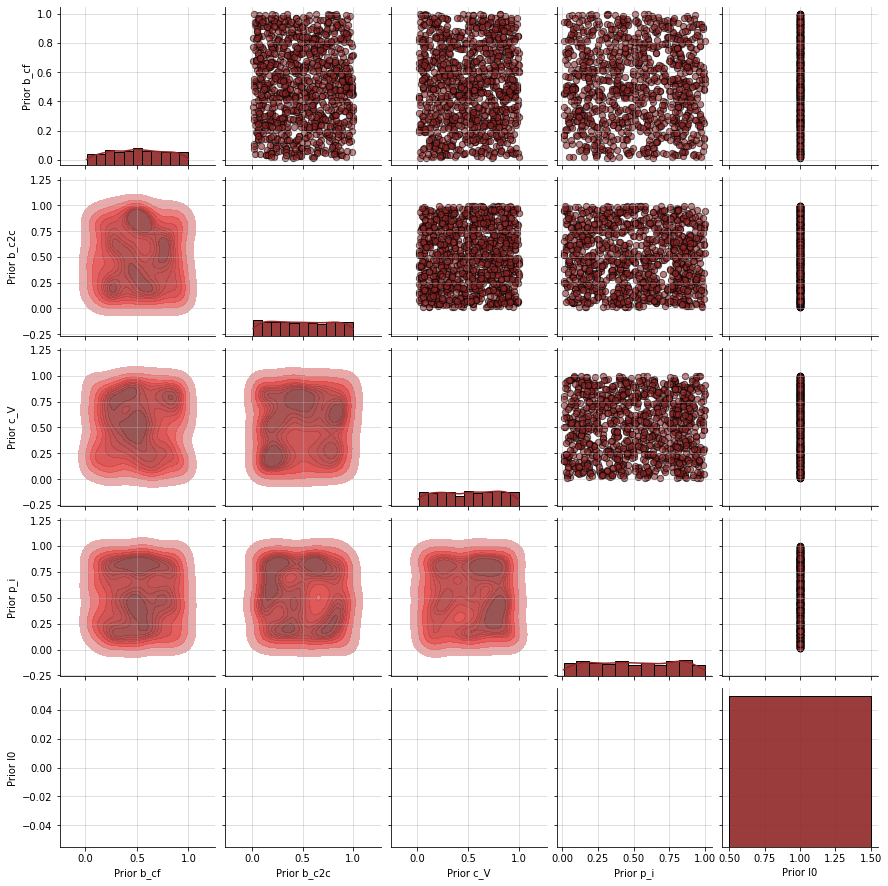

In [17]:
f = prior.plot_prior2d()

In [18]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, n_summary):
        super(ConvLSTM, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        out = self.lstm(out)
        return out

In [19]:
summary_net = ConvLSTM(n_summary=5)

2022-08-02 16:24:22.783230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 16:24:22.783262: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 16:24:22.783282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Terry): /proc/driver/nvidia/version does not exist
2022-08-02 16:24:22.783730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
inference_net = InvertibleNetwork({
    'n_params': 5, 
    'n_coupling_layers': 3, 
})

In [21]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='amortizer')

In [22]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {}
    
    # Convert data to logscale 
    logdata = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [23]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input)

INFO:root:Performing a consistency check with provided components...


/home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.1377855381164911_bc2c-0.6435777432110866_cV-0.22557570972442745_pi-0.5590842563484173


192.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.1377855381164911_bc2c-0.6435777432110866_cV-0.22557570972442745_pi-0.5590842563484173“ kann nicht angelegt werden: Die Datei existiert bereits


197.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.1377855381164911_bc2c-0.6435777432110866_cV-0.22557570972442745_pi-0.5590842563484173
Initializing from file /home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659450308
Random seed of thread 5 = 6560650
Random seed of thread 6 = 8731522
Random seed of thread 1 = 6272472
Random seed of thread 3 = 8261281
Random seed of thread 7 = 7903979
Random seed of thread 4 = 7117892
Random seed of thread 2 = 6316049
Registering Symbol space of linktype LocationLink in Scope root
Registering Symbol space.x of linktype VectorComponentLink in Scope root
Registering Symbol space.y of linktype VectorComponentLink in Scope root
Registering Symbol space.z of linktype VectorComponentLink in Scope root
Registering Symbol space.ph

206.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.6464849584975775_bc2c-0.6567750647319721_cV-0.9618197132020733_pi-0.5851499149234667“ kann nicht angelegt werden: Die Datei existiert bereits


211.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.6464849584975775_bc2c-0.6567750647319721_cV-0.9618197132020733_pi-0.5851499149234667
Initializing from file /home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659450322
Random seed of thread 5 = 4645514
Random seed of thread 6 = 1441093
Random seed of thread 1 = 8173341
Random seed of thread 7 = 7182182
Random seed of thread 2 = 1075129
Random seed of thread 3 = 9296803
Random seed of thread 4 = 5185165
Registering Symbol space of linktype LocationLink in Scope root
Registering Symbol space.x of linktype VectorComponentLink in Scope root
Registering Symbol space.y of linktype VectorComponentLink in Scope root
Registering Symbol space.z of linktype VectorComponentLink in Scope root
Registering Symbol space.phi

/tmp/ipykernel_312675/3937465181.py:14: RuntimeWarning: invalid value encountered in true_divide
  params = (params - prior_means) / prior_stds
INFO:root:Done.


In [24]:
amortizer.summary()

Model: "amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 58458     
 bleNetwork)                                                     
                                                                 
 conv_lstm (ConvLSTM)        multiple                  715       
                                                                 
Total params: 59,173
Trainable params: 59,143
Non-trainable params: 30
_________________________________________________________________


In [ ]:
#%%time
#_ = model(32)

/home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593
mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593
Initializing from file /home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659444320
Random seed of thread 7 = 8247125
Random seed of thread 4 = 3191454
Random seed

In [25]:
%%time
h = trainer.train_online(epochs=1, iterations_per_epoch=1, batch_size=1)

Training epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

/home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593


431.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593“ kann nicht angelegt werden: Die Datei existiert bereits


436.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Setting output directory /home/lea/projects/INN/morpheus/tutorial/infectionSpread/output/bcf-0.9177459907452441_bc2c-0.9645989723887219_cV-0.8174124693613288_pi-0.6171788015804593
Initializing from file /home/lea/projects/INN/morpheus/tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659450547
Random seed of thread 3 = 638727
Random seed of thread 4 = 6480890
Random seed of thread 2 = 810210
Random seed of thread 5 = 7301083
Random seed of thread 1 = 5591260
Random seed of thread 7 = 4327579
Random seed of thread 6 = 9136746
Registering Symbol space of linktype LocationLink in Scope root
Registering Symbol space.x of linktype VectorComponentLink in Scope root
Registering Symbol space.y of linktype VectorComponentLink in Scope root
Registering Symbol space.z of linktype VectorComponentLink in Scope root
Registering Symbol space.phi o

/tmp/ipykernel_312675/3937465181.py:14: RuntimeWarning: invalid value encountered in true_divide
  params = (params - prior_means) / prior_stds


CPU times: user 20.7 s, sys: 1.59 s, total: 22.3 s
Wall time: 9min


In [26]:
h

,Default.Loss
0,NaN


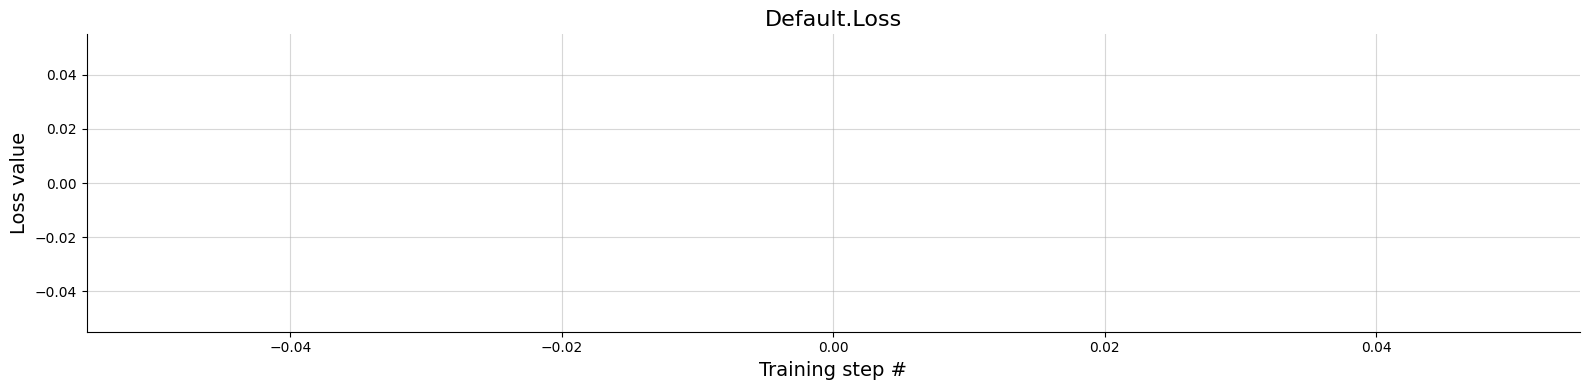

In [32]:
f = diag.plot_losses(h)

In [27]:
f = trainer.diagnose_latent2d()

982.51s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/ins

AttributeError: Exception encountered when calling layer "amortizer" (type AmortizedPosterior).

'NoneType' object has no attribute 'get'

Call arguments received by layer "amortizer" (type AmortizedPosterior):
  • input_dict=None
  • return_summary=False
  • kwargs={'training': 'None'}

In [28]:
f = trainer.diagnose_sbc_histograms()

TypeError: 'NoneType' object is not subscriptable

In [15]:
b_cf = 1
b_c2c = 1
c_V = 1
p_i = 1
I0 = 1
params = np.array([b_cf, b_c2c, c_V, p_i, I0])

In [17]:
pop = run_morpheus(params, 10, 100)

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
Initializing from file /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659355370
Random seed of thread 7 = 9507902
Random seed of thread 6 = 6909739
Random seed of thread 3 = 267710
Random seed of thread 1 = 1639870
Random seed of thread 2 = 8365403
Random seed of thread 4 = 751819
Random seed of thread 5 = 2297337
Registering Symbol space of linktype LocationLink in Scope root
Reg

In [46]:
pop = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop[:,2]

In [30]:
OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
population_file = os.path.join(OUT,'logger_3.csv')
pop = np.genfromtxt(population_file, delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop = np.expand_dims(pop[2,:], axis=1)

In [19]:
popul = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)

In [31]:
pop

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 7.],
       [ 9.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
      

In [26]:
popul[2,:]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,
        4.,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [13]:
model_dir='model'
models=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))
model=models[0]
!echo "$model"
#!morpheus -f '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml' -o '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1'

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
